## The Battle of Neighborhoods in NY

## Introduction
The objective of this project is to help an international investment group to know more about the consumer behavior in NY, so they can make a decision on their plan to open one of the group's most popular venues: an authentic Italian restaurant.
Although NY is one of the most multicultural cities in the world (which is in this case positive, as it means it is also welcoming to foreign food and culture), it is additionally one of the most populated in the US, which means it can potentially be saturated with venues like cafes and restaurants. Therefore, it is very important for the investment group to know not only about the competition they could face, but also about what kind of venues New Yorkers like (and visit) the most. Ultimately, it is expected that a recommendation regarding ideal neighborhood for the opening of their Italian restaurant is included in the report.


## Data
For the purpose of this project I will use the following data:
+ A dataset that contains the boroughs and neighborhoods in NY as well as the latitude and longitude coordinates of each neighborhood. 
+ The Foursquare API to get the information about the venues in each neighborhood.
+ The geospatial data of NY to understand the planning and boundaries of each neighborhood within the city.

   In order to expand/deepen my analysis about the consumer, I will use Google to search for information about each neighborhood, its history, significant trends and statistics that may help me gain a better understanding of the underlying behavior regarding dining and entertainment.

# Methodology

### Loading and Exploring the Data

In [1]:
#Importing all the dependencies that I'll need

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [2]:
#Downloading dataset:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
#Loading data:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [4]:
#Defining a new variable that includes the neighborhood information
neighborhoods_data = newyork_data['features']

In [5]:
#Checking the first item
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [6]:
#Transforming the data into a Pandas df

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [7]:
#Looping through the data to fill the dataframe line by line
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
neighborhoods.shape

(306, 4)

In [10]:
#Mapping the neighborhoods in NY

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of New York City are 40.7127281, -74.0060152.


In [11]:
#Map of NY's neighborhoods 

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [12]:
#Calling the Foursquare API
CLIENT_ID = 'WUZ5C3X4XEXEH4GK3J1EFZLB5PKAZDKUN5TECU1JR4T1VSBL' # your Foursquare ID
CLIENT_SECRET = '20S253FKMJIB3UIACE1BZZ1EPQEJ3PZ3OE4NNZIHTB3OO4GO' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
radius = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


#url to search for most popular venues in NY
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, LIMIT)
url

Your credentails:
CLIENT_ID: WUZ5C3X4XEXEH4GK3J1EFZLB5PKAZDKUN5TECU1JR4T1VSBL
CLIENT_SECRET:20S253FKMJIB3UIACE1BZZ1EPQEJ3PZ3OE4NNZIHTB3OO4GO


'https://api.foursquare.com/v2/venues/search?client_id=WUZ5C3X4XEXEH4GK3J1EFZLB5PKAZDKUN5TECU1JR4T1VSBL&client_secret=20S253FKMJIB3UIACE1BZZ1EPQEJ3PZ3OE4NNZIHTB3OO4GO&ll=40.7127281,-74.0060152&v=20180604'

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d78f673b77c77002c217a19'},
 'response': {'venues': [{'id': '58f0cd8db1ec13241266420a',
    'name': 'New York',
    'location': {'address': '230 Broadway',
     'lat': 40.712784,
     'lng': -74.00594,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.712784,
       'lng': -74.00594}],
     'distance': 8,
     'postalCode': '10007',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['230 Broadway',
      'New York, NY 10007',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1ca941735',
      'name': 'Pizza Place',
      'pluralName': 'Pizza Places',
      'shortName': 'Pizza',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',
       'suffix': '.png'},
      'primary': True}],
    'delivery': {'id': '286948',
     'url': 'https://www.seamless.com/menu/dantes-new-york-166-william-st-new-york/286948?affiliate=1131&utm_source=

In [14]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# transform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,delivery.id,delivery.provider.icon.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.name,delivery.url,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",286948,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/dantes-new-york-...,False,58f0cd8db1ec13241266420a,230 Broadway,US,New York,United States,NaN,8,"[230 Broadway, New York, NY 10007, United States]","[{'label': 'display', 'lat': 40.712784, 'lng':...",40.712784,-74.005940,10007,NY,New York,v-1568208499,NaN
1,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",NaN,NaN,NaN,NaN,NaN,NaN,False,4b57b0dff964a520293c28e3,Warren St.,US,New York,United States,at Broadway,107,"[Warren St. (at Broadway), New York, NY 10038,...","[{'label': 'display', 'lat': 40.71339431394821...",40.713394,-74.006934,10038,NY,MTA Subway - City Hall (R/W),v-1568208499,NaN
2,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",NaN,NaN,NaN,NaN,NaN,NaN,False,3fd66200f964a520d8f11ee3,17 Park Row,US,New York,United States,btwn Broadway & Centre St,69,"[17 Park Row (btwn Broadway & Centre St), New ...",NaN,40.712415,-74.006724,10038,NY,City Hall Park,v-1568208499,NaN
3,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",NaN,NaN,NaN,NaN,NaN,NaN,False,4a676321f964a52051c91fe3,260 E Broadway,US,New York,United States,at Murray St,13,"[260 E Broadway (at Murray St), New York, NY 1...",NaN,40.712659,-74.005880,10002,NY,New York City Hall,v-1568208499,186051114
4,"[{'id': '4bf58dd8d48988d128951735', 'name': 'G...",NaN,NaN,NaN,NaN,NaN,NaN,False,4b79a5e8f964a52037082fe3,234 Canal St,US,New York,United States,at Centre St.,3,"[234 Canal St (at Centre St.), New York, NY 10...","[{'label': 'display', 'lat': 40.71273261495395...",40.712733,-74.005978,10013,NY,NY Gift Shop,v-1568208499,NaN


In [15]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,New York,Pizza Place,230 Broadway,US,New York,United States,NaN,8,"[230 Broadway, New York, NY 10007, United States]","[{'label': 'display', 'lat': 40.712784, 'lng':...",40.712784,-74.005940,10007,NY,58f0cd8db1ec13241266420a
1,MTA Subway - City Hall (R/W),Metro Station,Warren St.,US,New York,United States,at Broadway,107,"[Warren St. (at Broadway), New York, NY 10038,...","[{'label': 'display', 'lat': 40.71339431394821...",40.713394,-74.006934,10038,NY,4b57b0dff964a520293c28e3
2,City Hall Park,Park,17 Park Row,US,New York,United States,btwn Broadway & Centre St,69,"[17 Park Row (btwn Broadway & Centre St), New ...",NaN,40.712415,-74.006724,10038,NY,3fd66200f964a520d8f11ee3
3,New York City Hall,City Hall,260 E Broadway,US,New York,United States,at Murray St,13,"[260 E Broadway (at Murray St), New York, NY 1...",NaN,40.712659,-74.005880,10002,NY,4a676321f964a52051c91fe3
4,NY Gift Shop,Gift Shop,234 Canal St,US,New York,United States,at Centre St.,3,"[234 Canal St (at Centre St.), New York, NY 10...","[{'label': 'display', 'lat': 40.71273261495395...",40.712733,-74.005978,10013,NY,4b79a5e8f964a52037082fe3
5,Citi Bike Station,Bike Rental / Bike Share,Centre St & Chambers St,US,New York,United States,NaN,8,"[Centre St & Chambers St, New York, NY, United...","[{'label': 'display', 'lat': 40.71279048859839...",40.712790,-74.005950,NaN,NY,51a16e778bbd0c6641889870
6,Barns & Noble at Pace University,College Bookstore,41 Park Row,US,New York,United States,at Spruce St,73,"[41 Park Row (at Spruce St), New York, NY 1003...","[{'label': 'display', 'lat': 40.71338917492071...",40.713389,-74.005944,10038,NY,4cd03c85a03a9eb0c158b103
7,Garden Of Eden,Flower Shop,Fulton St,US,New York,United States,NaN,8,"[Fulton St, New York, NY, United States]","[{'label': 'display', 'lat': 40.71278797046345...",40.712788,-74.005953,NaN,NY,52753553498e60add54f2434
8,City Hall Council Chambers,City Hall,City Hall,US,New York,United States,NaN,45,"[City Hall, New York, NY 10007, United States]","[{'label': 'display', 'lat': 40.71273609783686...",40.712736,-74.005472,10007,NY,51a4bc7c498e469047be66d6
9,Mary's Coffee Shop,Coffee Shop,25-15 Queens Plz N,US,Long Island City,United States,NaN,8,"[25-15 Queens Plz N, Long Island City, NY 1110...","[{'label': 'display', 'lat': 40.71278567220636...",40.712786,-74.005944,11101,NY,4b475390f964a520f12e26e3


In [16]:
dataframe_filtered.categories

0                                  Pizza Place
1                                Metro Station
2                                         Park
3                                    City Hall
4                                    Gift Shop
5                     Bike Rental / Bike Share
6                            College Bookstore
7                                  Flower Shop
8                                    City Hall
9                                  Coffee Shop
10                           Indian Restaurant
11                                  Courthouse
12                         Government Building
13                                       Beach
14                           College Classroom
15                               Jewelry Store
16                                 Pizza Place
17                         Government Building
18    Residential Building (Apartment / Condo)
19                                  Food Truck
20                                        None
21           

From the data above, we can see that there are no Italian Restaurants among the most popular venues in NY. Nonetheless, there are are a couple of Pizza places in that list, which means there is a market for italian food. We would have to dig deeper to understand if New Yorkers prefer italian fast food (i.e. pizza) rather than a more sophisticated restaurant.

### Exploring the data regarding Italian venues specifically

In [17]:
#Calling the Foursquare API
CLIENT_ID = 'WUZ5C3X4XEXEH4GK3J1EFZLB5PKAZDKUN5TECU1JR4T1VSBL' # your Foursquare ID
CLIENT_SECRET = '20S253FKMJIB3UIACE1BZZ1EPQEJ3PZ3OE4NNZIHTB3OO4GO' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WUZ5C3X4XEXEH4GK3J1EFZLB5PKAZDKUN5TECU1JR4T1VSBL
CLIENT_SECRET:20S253FKMJIB3UIACE1BZZ1EPQEJ3PZ3OE4NNZIHTB3OO4GO


In [18]:
search_query = 'Italian'
radius = 1000
print(search_query + ' .... OK!')

Italian .... OK!


In [19]:
#url to search for Italian 
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=WUZ5C3X4XEXEH4GK3J1EFZLB5PKAZDKUN5TECU1JR4T1VSBL&client_secret=20S253FKMJIB3UIACE1BZZ1EPQEJ3PZ3OE4NNZIHTB3OO4GO&ll=40.7127281,-74.0060152&v=20180604&query=Italian&radius=1000&limit=100'

In [20]:
resultsitalian = requests.get(url).json()
resultsitalian

{'meta': {'code': 200, 'requestId': '5d78f6730d2be7002c810c4d'},
 'response': {'venues': [{'id': '4a4560a7f964a5201aa81fe3',
    'name': "Harry's Italian Pizza Bar",
    'location': {'address': '2 Gold St',
     'crossStreet': 'at Maiden Ln.',
     'lat': 40.7076335455641,
     'lng': -74.00699585960496,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.7076335455641,
       'lng': -74.00699585960496}],
     'distance': 573,
     'postalCode': '10038',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['2 Gold St (at Maiden Ln.)',
      'New York, NY 10038',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d110941735',
      'name': 'Italian Restaurant',
      'pluralName': 'Italian Restaurants',
      'shortName': 'Italian',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
       'suffix': '.png'},
      'primary': True}],
    'delivery': {'id': '294543',


In [21]:
# assign relevant part of JSON to venues
venues2 = resultsitalian['response']['venues']

# tranform venues into a dataframe
dataframeItalian = json_normalize(venues2)
dataframeItalian.head()

,categories,delivery.id,delivery.provider.icon.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.name,delivery.url,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",294543,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/harrys-italian-2...,False,4a4560a7f964a5201aa81fe3,2 Gold St,US,New York,United States,at Maiden Ln.,573,"[2 Gold St (at Maiden Ln.), New York, NY 10038...","[{'label': 'display', 'lat': 40.7076335455641,...",40.707634,-74.006996,NaN,10038,NY,Harry's Italian Pizza Bar,v-1568208499,77559825
1,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",286355,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/pisillo-97-nassa...,False,528bf16711d2b7722da6b51c,97 Nassau St,US,New York,United States,at Ann St,275,"[97 Nassau St (at Ann St), New York, NY 10038,...","[{'label': 'display', 'lat': 40.71053008446078...",40.710530,-74.007526,NaN,10038,NY,Pisillo Italian Panini,v-1568208499,105457747
2,"[{'id': '4bf58dd8d48988d190941735', 'name': 'H...",NaN,NaN,NaN,NaN,NaN,NaN,False,4b9d4c67f964a5206ca136e3,155 Mulberry St,US,New York,United States,at Grand St,1024,"[155 Mulberry St (at Grand St), New York, NY 1...","[{'label': 'display', 'lat': 40.71919065572268...",40.719191,-73.997376,NaN,10013,NY,Italian American Museum,v-1568208499,66342615
3,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",NaN,NaN,NaN,NaN,NaN,NaN,False,588a4316326c5a4b60559f17,NaN,US,New York,United States,NaN,280,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.71049280792626...",40.710493,-74.007546,NaN,NaN,NY,Pisillo Italian Cafe,v-1568208499,NaN
4,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",294544,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/harrys-italian-p...,False,4fa862b3e4b0ebff2f749f06,225 Murray St,US,New York,United States,NaN,786,"[225 Murray St, New York, NY 10282, United Sta...","[{'label': 'display', 'lat': 40.71521779064671...",40.715218,-74.014739,NaN,10282,NY,Harry's Italian Pizza Bar,v-1568208499,NaN


In [22]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframeItalian.columns if col.startswith('location.')] + ['id']
dataframeItalian_filtered = dataframeItalian.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframeItalian_filtered['categories'] = dataframeItalian_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframeItalian_filtered.columns = [column.split('.')[-1] for column in dataframeItalian_filtered.columns]

dataframeItalian_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Harry's Italian Pizza Bar,Italian Restaurant,2 Gold St,US,New York,United States,at Maiden Ln.,573,"[2 Gold St (at Maiden Ln.), New York, NY 10038...","[{'label': 'display', 'lat': 40.7076335455641,...",40.707634,-74.006996,NaN,10038,NY,4a4560a7f964a5201aa81fe3
1,Pisillo Italian Panini,Sandwich Place,97 Nassau St,US,New York,United States,at Ann St,275,"[97 Nassau St (at Ann St), New York, NY 10038,...","[{'label': 'display', 'lat': 40.71053008446078...",40.710530,-74.007526,NaN,10038,NY,528bf16711d2b7722da6b51c
2,Italian American Museum,History Museum,155 Mulberry St,US,New York,United States,at Grand St,1024,"[155 Mulberry St (at Grand St), New York, NY 1...","[{'label': 'display', 'lat': 40.71919065572268...",40.719191,-73.997376,NaN,10013,NY,4b9d4c67f964a5206ca136e3
3,Pisillo Italian Cafe,Café,NaN,US,New York,United States,NaN,280,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.71049280792626...",40.710493,-74.007546,NaN,NaN,NY,588a4316326c5a4b60559f17
4,Harry's Italian Pizza Bar,Pizza Place,225 Murray St,US,New York,United States,NaN,786,"[225 Murray St, New York, NY 10282, United Sta...","[{'label': 'display', 'lat': 40.71521779064671...",40.715218,-74.014739,NaN,10282,NY,4fa862b3e4b0ebff2f749f06
5,Benvenuti Italian Specialties,Gourmet Shop,235 S End Ave,US,New York,United States,NaN,949,"[235 S End Ave, New York, NY 10280, United Sta...","[{'label': 'display', 'lat': 40.70968105555279...",40.709681,-74.016520,NaN,10280,NY,4f3feae2e4b0ac9416a72118
6,Center for Italian Modern Art,Art Gallery,421 Broome St Fl 4,US,New York,United States,Crosby St,1134,"[421 Broome St Fl 4 (Crosby St), New York, NY ...","[{'label': 'display', 'lat': 40.72118752815872...",40.721188,-73.998515,NaN,10013,NY,53132d23498eacec1e539180
7,Di So's Italian Food Truck,Italian Restaurant,NaN,US,New York,United States,NaN,999,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.70397251406873...",40.703973,-74.008627,Financial District,NaN,NY,51e245e8498eb19e2e908b76
8,Italian Food Center,Italian Restaurant,161 Mulberry St,US,New York,United States,at Grand St.,1053,"[161 Mulberry St (at Grand St.), New York, NY ...","[{'label': 'display', 'lat': 40.71946584027863...",40.719466,-73.997250,NaN,10013,NY,51a63ef7498e9eedb94e0c5f
9,Caruso's Italian Restaurant,Italian Restaurant,42 Broadway,US,New York,United States,NaN,312,"[42 Broadway, New York, NY 10004, United States]","[{'label': 'display', 'lat': 40.71050909999999...",40.710509,-74.008276,NaN,10004,NY,4e4c4d28bd413c4cc66857a5


In [23]:
dataframeItalian_filtered.categories

0        Italian Restaurant
1            Sandwich Place
2            History Museum
3                      Café
4               Pizza Place
5              Gourmet Shop
6               Art Gallery
7        Italian Restaurant
8        Italian Restaurant
9        Italian Restaurant
10                     Food
11    College Arts Building
12           Clothing Store
13       Italian Restaurant
14           Scenic Lookout
15       Italian Restaurant
16       Italian Restaurant
17       Italian Restaurant
18              Pizza Place
19       Italian Restaurant
20       Italian Restaurant
21       Italian Restaurant
22       Italian Restaurant
23              Street Fair
Name: categories, dtype: object

From the categories list in our specific search for Italian venues, we can see that there is a market not only for pizza places but also (and specially) for Italian Restaurants. This result, although expected, is an important confirmation of the viability of the project for the Investment group. Now we will dig deeper into what borough/neighborhood represents the best opportunity for my client.

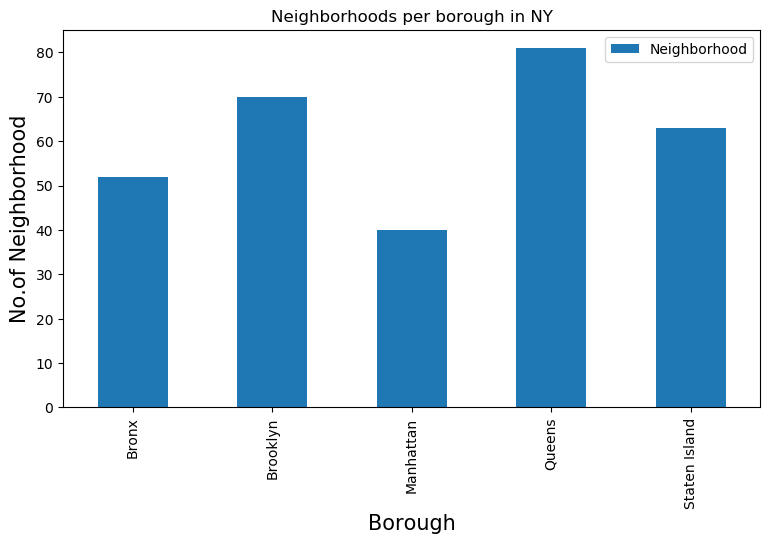

In [50]:
#Exploring a bit further the NY data
import matplotlib.pyplot as plt 

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Neighborhoods per borough in NY')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
neighborhoods.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Manhattan is the borough with the less number of neighborhoods and according to other sources of information it is the most sophisticated and vibrant of them all. It is also the smallest geographically but not the least populated and all these are great characteristics for a first time investor in the dining scene in NY. 

In [25]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [26]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Manhattan are 40.7900869, -73.9598295.


In [27]:
#Using Foursquare to explore italian venues in Manhattan
CLIENT_ID = 'WUZ5C3X4XEXEH4GK3J1EFZLB5PKAZDKUN5TECU1JR4T1VSBL' # your Foursquare ID
CLIENT_SECRET = '20S253FKMJIB3UIACE1BZZ1EPQEJ3PZ3OE4NNZIHTB3OO4GO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

search_query = 'Italian'
radius = 1000
print(search_query + ' .... OK!')

Your credentails:
CLIENT_ID: WUZ5C3X4XEXEH4GK3J1EFZLB5PKAZDKUN5TECU1JR4T1VSBL
CLIENT_SECRET:20S253FKMJIB3UIACE1BZZ1EPQEJ3PZ3OE4NNZIHTB3OO4GO
Italian .... OK!


In [28]:
resultsmanhattan = requests.get(url).json()
resultsmanhattan

{'meta': {'code': 200, 'requestId': '5d78f6742b274a0039d0bf3d'},
 'response': {'venues': [{'id': '4a4560a7f964a5201aa81fe3',
    'name': "Harry's Italian Pizza Bar",
    'location': {'address': '2 Gold St',
     'crossStreet': 'at Maiden Ln.',
     'lat': 40.7076335455641,
     'lng': -74.00699585960496,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.7076335455641,
       'lng': -74.00699585960496}],
     'distance': 573,
     'postalCode': '10038',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['2 Gold St (at Maiden Ln.)',
      'New York, NY 10038',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d110941735',
      'name': 'Italian Restaurant',
      'pluralName': 'Italian Restaurants',
      'shortName': 'Italian',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
       'suffix': '.png'},
      'primary': True}],
    'delivery': {'id': '294543',


In [29]:
# assign relevant part of JSON to venues
venues = resultsmanhattan['response']['venues']

# transform venues into a dataframe
dataframeManhattan = json_normalize(venues)
dataframeManhattan.head()

,categories,delivery.id,delivery.provider.icon.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.name,delivery.url,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",294543,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/harrys-italian-2...,False,4a4560a7f964a5201aa81fe3,2 Gold St,US,New York,United States,at Maiden Ln.,573,"[2 Gold St (at Maiden Ln.), New York, NY 10038...","[{'label': 'display', 'lat': 40.7076335455641,...",40.707634,-74.006996,NaN,10038,NY,Harry's Italian Pizza Bar,v-1568208500,77559825
1,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",286355,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/pisillo-97-nassa...,False,528bf16711d2b7722da6b51c,97 Nassau St,US,New York,United States,at Ann St,275,"[97 Nassau St (at Ann St), New York, NY 10038,...","[{'label': 'display', 'lat': 40.71053008446078...",40.710530,-74.007526,NaN,10038,NY,Pisillo Italian Panini,v-1568208500,105457747
2,"[{'id': '4bf58dd8d48988d190941735', 'name': 'H...",NaN,NaN,NaN,NaN,NaN,NaN,False,4b9d4c67f964a5206ca136e3,155 Mulberry St,US,New York,United States,at Grand St,1024,"[155 Mulberry St (at Grand St), New York, NY 1...","[{'label': 'display', 'lat': 40.71919065572268...",40.719191,-73.997376,NaN,10013,NY,Italian American Museum,v-1568208500,66342615
3,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",NaN,NaN,NaN,NaN,NaN,NaN,False,588a4316326c5a4b60559f17,NaN,US,New York,United States,NaN,280,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.71049280792626...",40.710493,-74.007546,NaN,NaN,NY,Pisillo Italian Cafe,v-1568208500,NaN
4,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",294544,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/harrys-italian-p...,False,4fa862b3e4b0ebff2f749f06,225 Murray St,US,New York,United States,NaN,786,"[225 Murray St, New York, NY 10282, United Sta...","[{'label': 'display', 'lat': 40.71521779064671...",40.715218,-74.014739,NaN,10282,NY,Harry's Italian Pizza Bar,v-1568208500,NaN


In [30]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframeManhattan.columns if col.startswith('location.')] + ['id']
dataframeManhattan_filtered = dataframeManhattan.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframeManhattan_filtered['categories'] = dataframeManhattan_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframeManhattan_filtered.columns = [column.split('.')[-1] for column in dataframeManhattan_filtered.columns]

dataframeManhattan_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Harry's Italian Pizza Bar,Italian Restaurant,2 Gold St,US,New York,United States,at Maiden Ln.,573,"[2 Gold St (at Maiden Ln.), New York, NY 10038...","[{'label': 'display', 'lat': 40.7076335455641,...",40.707634,-74.006996,NaN,10038,NY,4a4560a7f964a5201aa81fe3
1,Pisillo Italian Panini,Sandwich Place,97 Nassau St,US,New York,United States,at Ann St,275,"[97 Nassau St (at Ann St), New York, NY 10038,...","[{'label': 'display', 'lat': 40.71053008446078...",40.710530,-74.007526,NaN,10038,NY,528bf16711d2b7722da6b51c
2,Italian American Museum,History Museum,155 Mulberry St,US,New York,United States,at Grand St,1024,"[155 Mulberry St (at Grand St), New York, NY 1...","[{'label': 'display', 'lat': 40.71919065572268...",40.719191,-73.997376,NaN,10013,NY,4b9d4c67f964a5206ca136e3
3,Pisillo Italian Cafe,Café,NaN,US,New York,United States,NaN,280,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.71049280792626...",40.710493,-74.007546,NaN,NaN,NY,588a4316326c5a4b60559f17
4,Harry's Italian Pizza Bar,Pizza Place,225 Murray St,US,New York,United States,NaN,786,"[225 Murray St, New York, NY 10282, United Sta...","[{'label': 'display', 'lat': 40.71521779064671...",40.715218,-74.014739,NaN,10282,NY,4fa862b3e4b0ebff2f749f06
5,Benvenuti Italian Specialties,Gourmet Shop,235 S End Ave,US,New York,United States,NaN,949,"[235 S End Ave, New York, NY 10280, United Sta...","[{'label': 'display', 'lat': 40.70968105555279...",40.709681,-74.016520,NaN,10280,NY,4f3feae2e4b0ac9416a72118
6,Center for Italian Modern Art,Art Gallery,421 Broome St Fl 4,US,New York,United States,Crosby St,1134,"[421 Broome St Fl 4 (Crosby St), New York, NY ...","[{'label': 'display', 'lat': 40.72118752815872...",40.721188,-73.998515,NaN,10013,NY,53132d23498eacec1e539180
7,Di So's Italian Food Truck,Italian Restaurant,NaN,US,New York,United States,NaN,999,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.70397251406873...",40.703973,-74.008627,Financial District,NaN,NY,51e245e8498eb19e2e908b76
8,Italian Food Center,Italian Restaurant,161 Mulberry St,US,New York,United States,at Grand St.,1053,"[161 Mulberry St (at Grand St.), New York, NY ...","[{'label': 'display', 'lat': 40.71946584027863...",40.719466,-73.997250,NaN,10013,NY,51a63ef7498e9eedb94e0c5f
9,Caruso's Italian Restaurant,Italian Restaurant,42 Broadway,US,New York,United States,NaN,312,"[42 Broadway, New York, NY 10004, United States]","[{'label': 'display', 'lat': 40.71050909999999...",40.710509,-74.008276,NaN,10004,NY,4e4c4d28bd413c4cc66857a5


In [31]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) 

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframeManhattan_filtered.lat, dataframeManhattan_filtered.lng, dataframeManhattan_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

From the map we can see where most of the italian venues are located and where the white spaces are.

In [69]:
venue_id = '4a4560a7f964a5201aa81fe3'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url

'https://api.foursquare.com/v2/venues/4a4560a7f964a5201aa81fe3?client_id=WUZ5C3X4XEXEH4GK3J1EFZLB5PKAZDKUN5TECU1JR4T1VSBL&client_secret=20S253FKMJIB3UIACE1BZZ1EPQEJ3PZ3OE4NNZIHTB3OO4GO&v=20180605'

In [70]:
result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'hasMenu', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'delivery', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'venuePage', 'reasons', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


{'id': '4a4560a7f964a5201aa81fe3',
 'name': "Harry's Italian Pizza Bar",
 'contact': {'phone': '2127470797',
  'formattedPhone': '(212) 747-0797',
  'twitter': 'harrysitalian'},
 'location': {'address': '2 Gold St',
  'crossStreet': 'at Maiden Ln.',
  'lat': 40.7076335455641,
  'lng': -74.00699585960496,
  'labeledLatLngs': [{'label': 'display',
    'lat': 40.7076335455641,
    'lng': -74.00699585960496}],
  'postalCode': '10038',
  'cc': 'US',
  'city': 'New York',
  'state': 'NY',
  'country': 'United States',
  'formattedAddress': ['2 Gold St (at Maiden Ln.)',
   'New York, NY 10038',
   'United States']},
 'canonicalUrl': 'https://foursquare.com/v/harrys-italian-pizza-bar/4a4560a7f964a5201aa81fe3',
 'categories': [{'id': '4bf58dd8d48988d110941735',
   'name': 'Italian Restaurant',
   'pluralName': 'Italian Restaurants',
   'shortName': 'Italian',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
    'suffix': '.png'},
   'primary': True},
  {'id': '4bf58

In [71]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

8.1


This is generally a good rating. Not the best, but above average.

In [72]:
# Exploring the tips in Carmine's Italian Restaurant
limit = 15 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d7903a02c2017002b835062'},
 'response': {'tips': {'count': 141,
   'items': [{'id': '575f39f7498e5468ff5813d2',
     'createdAt': 1465858551,
     'text': "We got the half white, half red with pepperoni and sausage, square style. Yum yum. Harry's pizza crust is also amazing. Similar to Adrienne's.",
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/575f39f7498e5468ff5813d2',
     'photo': {'id': '575f39f8498e342e09af9c88',
      'createdAt': 1465858552,
      'source': {'name': 'Foursquare for iOS',
       'url': 'https://foursquare.com/download/#/iphone'},
      'prefix': 'https://fastly.4sqi.net/img/general/',
      'suffix': '/145373093_btR4hTdR2BUTnDY2GnTVL1XJMzCGndiPApaMgWkpYq0.jpg',
      'width': 1919,
      'height': 1201,
      'visibility': 'public'},
     'photourl': 'https://fastly.4sqi.net/img/general/original/145373093_btR4hTdR2BUTnDY2GnTVL1XJMzCGndiPApaMgWkpYq0.jpg',
     'lang': 'en',
     'likes': {'count': 1,


In [73]:
tips = results['response']['tips']['items']

tip = results['response']['tips']['items'][0]
tip.keys()

dict_keys(['id', 'createdAt', 'text', 'type', 'canonicalUrl', 'photo', 'photourl', 'lang', 'likes', 'logView', 'agreeCount', 'disagreeCount', 'lastVoteText', 'lastUpvoteTimestamp', 'todo', 'user', 'authorInteractionType'])

In [74]:
pd.set_option('display.max_colwidth', -1)

tips_df = json_normalize(tips) # json normalize tips

# columns to keep
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.gender', 'user.id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display tips
tips_filtered

,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.gender,user.id
0,"We got the half white, half red with pepperoni and sausage, square style. Yum yum. Harry's pizza crust is also amazing. Similar to Adrienne's.",6,0,575f39f7498e5468ff5813d2,Amanda,Ho,female,145373093


The tip from this user highlights the quality of the restaurant.

## Exploring data by neighborhood in Manhattan

In [82]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [83]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [84]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,100,100,100,100,100,100
Carnegie Hill,100,100,100,100,100,100
Central Harlem,44,44,44,44,44,44
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,44,44,44,44,44,44
East Village,100,100,100,100,100,100


In [85]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Sh

In [86]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Sh

In [87]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0  Park           0.09
1  Coffee Shop    0.07
2  Hotel          0.05
3  Gym            0.04
4  Memorial Site  0.04


----Carnegie Hill----
                 venue  freq
0  Pizza Place          0.06
1  Coffee Shop          0.06
2  Cosmetics Shop       0.04
3  Café                 0.04
4  Japanese Restaurant  0.03


----Central Harlem----
                 venue  freq
0  African Restaurant   0.07
1  Public Art           0.05
2  Bar                  0.05
3  French Restaurant    0.05
4  Fried Chicken Joint  0.05


----Chelsea----
                venue  freq
0  Coffee Shop         0.06
1  Ice Cream Shop      0.05
2  Bakery              0.05
3  Italian Restaurant  0.05
4  Nightclub           0.04


----Chinatown----
                   venue  freq
0  Chinese Restaurant     0.09
1  Cocktail Bar           0.05
2  Bakery                 0.04
3  American Restaurant    0.04
4  Vietnamese Restaurant  0.04


----Civic Center----
                  venue 

In [88]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [89]:
#Top 10 venues per neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Memorial Site,Gym,Italian Restaurant,Wine Shop,Food Court,Shopping Mall,BBQ Joint
1,Carnegie Hill,Coffee Shop,Pizza Place,Café,Cosmetics Shop,Yoga Studio,Spa,Bakery,Bar,Bookstore,French Restaurant
2,Central Harlem,African Restaurant,French Restaurant,Public Art,Gym / Fitness Center,Bar,Chinese Restaurant,Seafood Restaurant,Fried Chicken Joint,American Restaurant,Caribbean Restaurant
3,Chelsea,Coffee Shop,Ice Cream Shop,Bakery,Italian Restaurant,Nightclub,Seafood Restaurant,Hotel,American Restaurant,Theater,Bookstore
4,Chinatown,Chinese Restaurant,Cocktail Bar,Vietnamese Restaurant,American Restaurant,Bakery,Dumpling Restaurant,Salon / Barbershop,Spa,Malay Restaurant,Supermarket
5,Civic Center,Gym / Fitness Center,Italian Restaurant,Hotel,French Restaurant,Sandwich Place,Coffee Shop,Yoga Studio,Park,American Restaurant,Sporting Goods Shop
6,Clinton,Theater,Gym / Fitness Center,Italian Restaurant,American Restaurant,Spa,Wine Shop,Hotel,Mediterranean Restaurant,Gym,Indie Theater
7,East Harlem,Mexican Restaurant,Bakery,Deli / Bodega,Latin American Restaurant,Thai Restaurant,Coffee Shop,Gym,Grocery Store,Liquor Store,Park
8,East Village,Bar,Ice Cream Shop,Wine Bar,Mexican Restaurant,Chinese Restaurant,Pizza Place,Cocktail Bar,Ramen Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant
9,Financial District,Coffee Shop,Gym,Hotel,Pizza Place,Wine Shop,Gym / Fitness Center,Cocktail Bar,American Restaurant,Steakhouse,Food Truck


In [90]:
neighborhoods_venues_sorted["1st Most Common Venue"].value_counts()

Coffee Shop             7
Italian Restaurant      7
Café                    4
Park                    3
Bar                     3
Gym / Fitness Center    3
Sandwich Place          2
Theater                 2
Pizza Place             1
Korean Restaurant       1
African Restaurant      1
Boat or Ferry           1
Clothing Store          1
Mexican Restaurant      1
Hotel                   1
Bakery                  1
Chinese Restaurant      1
Name: 1st Most Common Venue, dtype: int64

In [91]:
neighborhoods_venues_sorted["2nd Most Common Venue"].value_counts()

Coffee Shop                6
Mexican Restaurant         4
Italian Restaurant         3
Clothing Store             2
Ice Cream Shop             2
Cocktail Bar               2
Café                       2
Pizza Place                2
Gym / Fitness Center       2
Gym                        2
Bakery                     2
American Restaurant        1
Japanese Restaurant        1
Hotel Bar                  1
Sushi Restaurant           1
Furniture / Home Store     1
Exhibit                    1
New American Restaurant    1
French Restaurant          1
Boutique                   1
Playground                 1
Yoga Studio                1
Name: 2nd Most Common Venue, dtype: int64

In [92]:
neighborhoods_venues_sorted["3rd Most Common Venue"].value_counts()

Italian Restaurant       5
Hotel                    5
Pizza Place              3
American Restaurant      3
Art Gallery              3
Café                     2
Wine Bar                 2
Deli / Bodega            2
Park                     2
Indian Restaurant        2
Steakhouse               1
Japanese Restaurant      1
Sushi Restaurant         1
Cocktail Bar             1
Public Art               1
Sandwich Place           1
Bakery                   1
Vietnamese Restaurant    1
Bookstore                1
Cosmetics Shop           1
Yoga Studio              1
Name: 3rd Most Common Venue, dtype: int64

In [93]:
neighborhoods_venues_sorted["4th Most Common Venue"].value_counts()

American Restaurant          3
French Restaurant            3
Café                         2
Pizza Place                  2
Italian Restaurant           2
Deli / Bodega                2
Sushi Restaurant             2
Gym / Fitness Center         2
Bakery                       2
Coffee Shop                  2
Mexican Restaurant           2
Japanese Restaurant          2
Clothing Store               1
Gym                          1
Wine Bar                     1
Memorial Site                1
Seafood Restaurant           1
Bar                          1
Bus Line                     1
Shoe Store                   1
Latin American Restaurant    1
Cosmetics Shop               1
Sandwich Place               1
Kids Store                   1
Spanish Restaurant           1
Jazz Club                    1
Name: 4th Most Common Venue, dtype: int64

In [94]:
neighborhoods_venues_sorted["5th Most Common Venue"].value_counts()

Coffee Shop                      4
Spa                              2
Gym                              2
Thai Restaurant                  2
Café                             2
Yoga Studio                      1
American Restaurant              1
Bar                              1
Concert Hall                     1
Gas Station                      1
Cosmetics Shop                   1
Theater                          1
Mobile Phone Shop                1
French Restaurant                1
Ramen Restaurant                 1
Salon / Barbershop               1
Gym / Fitness Center             1
Bagel Shop                       1
Lounge                           1
Wine Shop                        1
Deli / Bodega                    1
Pizza Place                      1
Japanese Restaurant              1
Park                             1
Chinese Restaurant               1
Vegetarian / Vegan Restaurant    1
Greek Restaurant                 1
Steakhouse                       1
Hotel               

From the above lists we can see that Italian restaurants and coffee shops are amongts the preferred venues in each neihborhood. This gives us a clearer idea on the type of venue and offering that our client should have in mind to tackle the NY consumer's interests.